In [1]:
from scipy.stats import ttest_ind
import datetime
import pandas as pd
import numpy as np
import pyfolio as pf
from backtester import Backtest
from plotly.subplots import make_subplots
from dotenv import dotenv_values
from binance.client import Client
import plotly.graph_objects as go
config = dotenv_values(".env")
client = Client(config.get('KEY'), config.get('SECKET_KEY'))

/home/serg/CRYPTO/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
'''
1. Install ta
https://github.com/bukosabino/ta
'''
def get_data(ticker, days):
    config = dotenv_values(".env")
    client = Client(config.get('KEY'), config.get('SECKET_KEY'))
    end = datetime.datetime.now()
    end = end - datetime.timedelta(days=0)
    start = end - datetime.timedelta(days=days)
    end = end.strftime('%d %b, %Y')
    start = start.strftime('%d %b, %Y')
    klines = client.get_historical_klines(
        ticker, Client.KLINE_INTERVAL_5MINUTE, start, end)
    data = pd.DataFrame(data=[row[1:7] for row in klines],
                        columns=[
        "open", "high", "low", "close", "volume", "time"]
    ).set_index("time")
    data.index = pd.to_datetime(data.index + 1, unit='ms')
    data = data.sort_index()
    data = data.apply(pd.to_numeric, axis=1)
    return data


In [3]:
data = get_data(ticker='BTCUSDT', days=90)
data.head(5)

,open,high,low,close,volume
time,,,,,
2021-01-18 00:05:00,35824.99,35982.92,35551.81,35645.19,974.960078
2021-01-18 00:10:00,35639.23,35820.21,35611.91,35715.71,256.072445
2021-01-18 00:15:00,35715.72,35826.71,35709.88,35763.70,132.043938
2021-01-18 00:20:00,35763.71,35930.14,35708.26,35860.82,197.368258
2021-01-18 00:25:00,35863.19,35926.76,35785.39,35868.87,221.122921


In [ ]:
# Describe Volume data

In [4]:
'''
The mean volume for 5 minute is 269.95 BTC
Standart devation is 235.57 BTC
The range for 75% of all observations between 143.74 BTC and 310.38 BTC
'''
data.volume.describe()

count    25888.000000
mean       269.955130
std        235.573686
min          0.000000
25%        143.745889
50%        204.449689
75%        310.381951
max       4886.769414
Name: volume, dtype: float64

In [5]:
'''
The histogram is shifted to the right. This means that there are a lot of abnormal volumes.
'''
fig = go.Figure()
fig.add_trace(go.Histogram(x=data.volume, name='Volume'))
fig.show()


In [6]:
'''
https://en.wikipedia.org/wiki/Quantile#:~:text=In%20statistics%20and%20probability%2C%20quantiles,the%20number%20of%20groups%20created.
'''
data['minutes'] = data.index.minute
data['hours'] = data.index.hour
data['days'] = data.index.day_of_week
data['quantile_volume'] =pd.qcut(data['volume'], 5, labels=['very_low', 'low', 'normal', 'high', 'very_high'])
data['quantile_volume'].value_counts()

very_low     5178
normal       5178
very_high    5178
low          5177
high         5177
Name: quantile_volume, dtype: int64

## Analyse volume per minutes

In [12]:
'''
The biggest volume at 5 minutes
The lowest volume at 45 minutes
'''
data.groupby('minutes', as_index=False).agg({'volume': 'mean'})

,minutes,volume
0,0,258.057134
1,5,330.150812
2,10,277.678586
3,15,269.466747
4,20,279.220241
5,25,264.553663
6,30,258.369258
7,35,275.190931
8,40,255.431687
9,45,250.131332


In [23]:
fig = go.Figure()
fig.add_trace(go.Bar(x=data.groupby('minutes', as_index=False).agg({'volume': 'mean'})['volume'], name='Volume'))
fig.show()

In [27]:
pd.crosstab(data['minutes'], data['quantile_volume'])

quantile_volume,very_low,low,normal,high,very_high
minutes,,,,,
0,479,452,440,377,409
5,264,304,413,518,659
10,402,416,404,461,474
15,446,434,432,410,435
20,390,403,452,443,469
25,438,427,437,440,415
30,474,453,432,417,381
35,394,427,444,452,441
40,454,474,451,407,373


## Analyse volume per hours

In [13]:
'''
The biggest volume in 12 hour
The lowest volume at 22 hour
'''
data.groupby('hours', as_index=False).agg({'volume': 'mean'})


,hours,volume
0,0,310.521003
1,1,257.486134
2,2,241.573609
3,3,217.054375
4,4,234.940462
5,5,219.102127
6,6,245.930888
7,7,248.372635
8,8,305.229162
9,9,342.143437


In [24]:
fig = go.Figure()
fig.add_trace(go.Bar(x=data.groupby('hours', as_index=False).agg({'volume': 'mean'})['volume'], name='Volume'))
fig.show()

In [28]:
pd.crosstab(data['hours'], data['quantile_volume'])

quantile_volume,very_low,low,normal,high,very_high
hours,,,,,
0,132,192,232,245,280
1,228,259,220,183,190
2,281,223,195,201,169
3,331,241,178,174,147
4,277,247,211,180,153
5,295,252,241,158,133
6,252,225,222,205,176
7,215,239,225,227,174
8,137,222,218,242,261


## Analyse volume per days

In [14]:
data.groupby('days', as_index=False).agg({'volume': 'mean'})


,days,volume
0,0,291.200431
1,1,288.891888
2,2,287.360452
3,3,272.187370
4,4,311.123552
5,5,230.154017
6,6,203.516273


In [25]:
fig = go.Figure()
fig.add_trace(go.Bar(x=data.groupby('days', as_index=False).agg({'volume': 'mean'})['volume'], name='Volume'))
fig.show()

In [26]:
pd.crosstab(data['days'], data['quantile_volume'])

quantile_volume,very_low,low,normal,high,very_high
days,,,,,
0,657,728,775,785,798
1,588,716,812,787,841
2,440,705,773,941,885
3,597,756,807,783,786
4,672,683,678,725,986
5,1026,838,695,639,528
6,1198,751,638,517,354


### Statistical Test

In [13]:
'''
What is  T - test?
https://www.investopedia.com/terms/t/t-test.asp
With this test, we determine that the values are not random. If the values are greater than 5%, then we can reject the hypothesis that the values are random.

'''
group = data.groupby('minutes')['volume'].apply(lambda x:list(x))
for index, value in group.iteritems():
    statistical_test =ttest_ind(data['volume'], value, equal_var=False)
    if statistical_test[1] > 0.05:
        print(index ,statistical_test)

10 Ttest_indResult(statistic=-1.5334318773185376, pvalue=0.12529253879311664)
15 Ttest_indResult(statistic=0.08991754066789706, pvalue=0.9283599282437527)
20 Ttest_indResult(statistic=-1.6741557199400552, pvalue=0.09422550923613253)
25 Ttest_indResult(statistic=1.044271662259827, pvalue=0.2964588453194055)
35 Ttest_indResult(statistic=-1.0211537719515604, pvalue=0.3072782551553226)
50 Ttest_indResult(statistic=0.8474122080001137, pvalue=0.39684559252082796)


## Backtest

### Simple backtest

/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='time'>

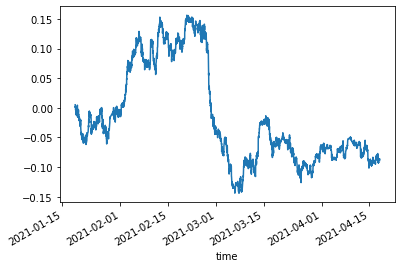

In [83]:
LAG = 3
data.loc[:, 'y'] = data['close'].shift(-LAG).pct_change()
data = data.dropna()
# data.loc[:, 'signal'] = np.where((data['quantile_volume'] == 'very_low') | (data['quantile_volume'] == 'low'), 1, 0)
data.loc[:, 'signal'] = np.where(data['quantile_volume'] == 'normal', 1, 0)
# data.loc[:, 'signal'] = np.where(data['quantile_volume'] == 'very_low', -1, data['signal'])
data[data['signal'] == 1]['y'].cumsum().plot()

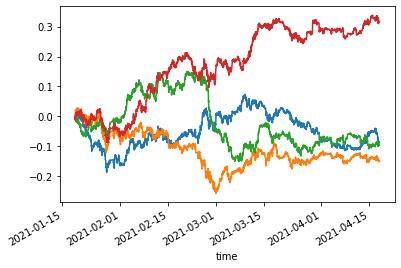

In [65]:
lags = np.arange(1, 5)
for i in lags:
    data.loc[:, 'y'] = data['close'].shift(-i).pct_change()
    data = data.dropna()
    # data.loc[:, 'signal'] = np.where((data['quantile_volume'] == 'very_low') | (data['quantile_volume'] == 'low'), 1, 0)
    data.loc[:, 'signal'] = np.where(data['quantile_volume'] == 'normal', 1, 0)
    data[data['signal'] == 1]['y'].cumsum().plot() # Find input lebels


## Revise statistical effect

In [67]:
'''
If pvalue more than 0.05 (5%). It means statistics is working. We could input this statisitcal in our strategy
'''
ttest_ind(
    data[data['signal'] == 1]['y'],
    data['y'], equal_var=False
    )

Ttest_indResult(statistic=0.8880313929633716, pvalue=0.3745508957871032)

In [73]:
'''
1. Make hypotesis  (your ideas)
1.1. Describe statistical
2. Check statistical using t-test (find p-Value). If it (more than 5%) working go in next step
3. Create simple backtest
3.1 Find the best lag
4. Use comples backtest (take profit, stop loss, kind of backtest: "exit by signal", "exit by lag", "exit by take profit or stopp loss")

'''

'\n1. Make hypotesis  (your ideas)\n1.1. Describe statistical\n2. Check statistical using t-test (find p-Value). If it (more than 5%) working go in next step\n3. Create simple backtest\n3.1 Find the best lag\n4. Use comples backtest (take profit, stop loss, kind of backtest: "exit by signal", "exit by lag", "exit by take profit or stopp loss")\n\n'

In [ ]:
'''
Exit by signal
'''
back = Backtest()
returns = back.exit_by_signal(data=data, take_profit=0.01, stop_loss=-0.01, comission=0)
returns['cumsum'].plot()

<AxesSubplot:xlabel='time'>

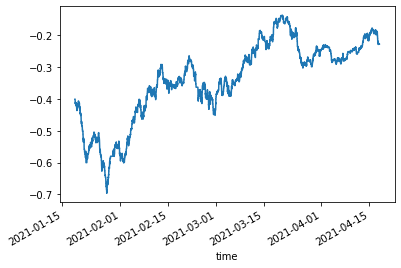

In [70]:
'''
Exit by lag
'''
returns = back.exit_by_lag(data=data, take_profit=0.01, stop_loss=-0.01, lag=5, comission=0)
returns['cumsum'].plot()

<AxesSubplot:xlabel='time'>

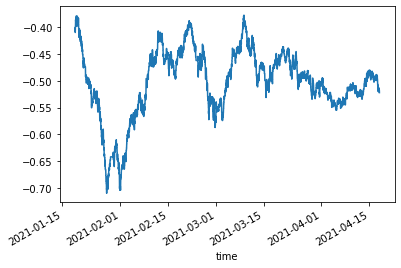

In [72]:
'''
Exit by take profit and stop loss
'''
returns = back.exit_by_take(data=data, take_profit=0.003, stop_loss=-0.003, comission=0)
returns['cumsum'].plot()

### Add new variabels to improve result

In [84]:
#### Add support line and resistance line
ROLLING_WINDOW = 12
SIGMA = 2
data['std'] = data['close'].pct_change().rolling(ROLLING_WINDOW).std()
sigma = data['std'].mean() * SIGMA
data.loc[:, 'support_line'] = np.where(data['std'] < SIGMA, 1, 0)
data.loc[:, 'resistance_line'] = np.where(data['std'] > SIGMA, 1, 0)
print(sigma)


0.005163935637120146
<ipython-input-84-c603e4747456>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [85]:
data_hm = data.copy()
data_hm['signal'] = np.where((data['signal'] == 1) & (data['support_line'] == 1), 1, 0)

/home/serg/CRYPTO/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='time'>

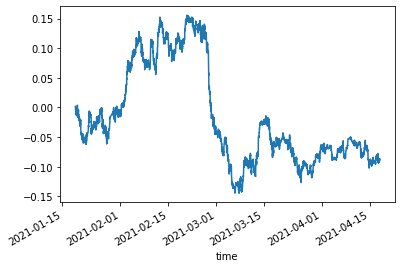

In [87]:
LAG = 3
data_hm.loc[:, 'y'] = data_hm['close'].shift(-LAG).pct_change()
data_hm = data_hm.dropna()
data_hm.loc[:, 'signal'] = np.where(data_hm['quantile_volume'] == 'normal', 1, 0)
data_hm[data_hm['signal'] == 1]['y'].cumsum().plot()

In [ ]:
# Support line?